# Isolation Forest

In [1]:
import datetime as dt
import itertools as it

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import shap

import joblib

from sklearn.ensemble import IsolationForest

In [2]:
NO_FEATURES = ['id', 'tile', 'cnt', 'ra_k', 'dec_k']

FEATURES = [
   'Amplitude', 'Autocor_length',
   'Beyond1Std', 'Con', 'Eta_e', 'FluxPercentileRatioMid20',
   'FluxPercentileRatioMid35', 'FluxPercentileRatioMid50',
   'FluxPercentileRatioMid65', 'FluxPercentileRatioMid80',
   'Freq1_harmonics_amplitude_0', 'Freq1_harmonics_amplitude_1',
   'Freq1_harmonics_amplitude_2', 'Freq1_harmonics_amplitude_3',
   'Freq1_harmonics_rel_phase_1', 'Freq1_harmonics_rel_phase_2',
   'Freq1_harmonics_rel_phase_3', 'Freq2_harmonics_amplitude_0',
   'Freq2_harmonics_amplitude_1', 'Freq2_harmonics_amplitude_2',
   'Freq2_harmonics_amplitude_3', 'Freq2_harmonics_rel_phase_1',
   'Freq2_harmonics_rel_phase_2', 'Freq2_harmonics_rel_phase_3',
   'Freq3_harmonics_amplitude_0', 'Freq3_harmonics_amplitude_1',
   'Freq3_harmonics_amplitude_2', 'Freq3_harmonics_amplitude_3',
   'Freq3_harmonics_rel_phase_1', 'Freq3_harmonics_rel_phase_2',
   'Freq3_harmonics_rel_phase_3', 'Gskew', 'LinearTrend', 'MaxSlope',
   'Mean', 'MedianAbsDev', 'MedianBRP', 'PairSlopeTrend',
   'PercentAmplitude', 'PercentDifferenceFluxPercentile', 'PeriodLS',
   'Period_fit', 'Psi_CS', 'Psi_eta', 'Q31', 'Rcs', 'Skew',
   'SmallKurtosis', 'Std', 'c89_c3', 'c89_hk_color', 'c89_jh_color',
   'c89_jk_color', 'c89_m2', 'c89_m4', 'n09_c3', 'n09_hk_color',
   'n09_jh_color', 'n09_jk_color', 'n09_m2', 'n09_m4', 'ppmb']

MIN_SAMPLES = len(FEATURES) * 2

In [3]:
%%time

datas = {
    "b216": joblib.load("_data/blz_b216_3849_scaled.pkl.bz2"),
    "b277": joblib.load("_data/blz_b277_3041_scaled.pkl.bz2")
}

CPU times: user 1min 18s, sys: 475 ms, total: 1min 19s
Wall time: 1min 19s


In [14]:
%%time
locals().update(joblib.load("results/results.pkl.bz2"))

CPU times: user 38.4 s, sys: 251 ms, total: 38.7 s
Wall time: 38.7 s


In [5]:
from collections import Counter

for k, v in results.items():
    cnt = Counter(v)
    print(f"Outliers in Tile {k}: {cnt[-1] / len(v) * 100:.3f}%")

Outliers in Tile b216: 5.246%
Outliers in Tile b277: 5.072%


https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

In [6]:
def plot_shaps(tile):
    k = tile

    # calculo la media de los valores absolutos
    # del shap del tile
    means = np.mean(np.abs(shaps[k]), axis=0)

    # ordenamos los features segun su importancia
    order = np.argsort(means)
    means = means[order]
    names = np.array(FEATURES)[order]

    # normalizo los valores entre 0 y 1
    norm_means = means / np.sum(means)

    # me fijo cual es y a que feature pertenece el
    # limite de cuantos son los features que suman el
    # 20% de que mas explican al clasificador
    u20_limit = np.percentile(norm_means, 80)
    u20_n = (norm_means >= u20_limit).sum()

    shap.summary_plot(
        shaps[k],
        datas[k][FEATURES].values, 
        max_display=u20_n,
        feature_names=FEATURES, 
        plot_type="bar")
    
    return names[::-1][:u20_n]

def plot_dists(tile, efeats):
    k = tile
    tresults = results[k]
    normal = datas[k][tresults == 1]
    outliers = datas[k][tresults == -1]

    ffig, axes = plt.subplots(16, 4, figsize=(4 * 5, 3 * 16))
    axes = it.chain(*axes)

    for feat, ax in zip(FEATURES, axes):
        suffix = " (Upper 20%)" if feat in efeats else ""
        color = "gr" if feat in efeats else (None, None)
        
        sns.distplot(normal[feat], ax=ax, label="Normal values", color=color[0])
        sns.distplot(outliers[feat], ax=ax, label="Outliers", color=color[1])
        
        ax.set_title(f"{k} - {feat}" + suffix)
        ax.legend()

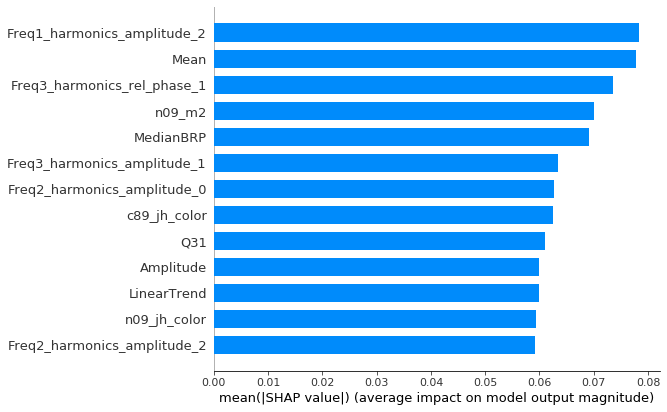

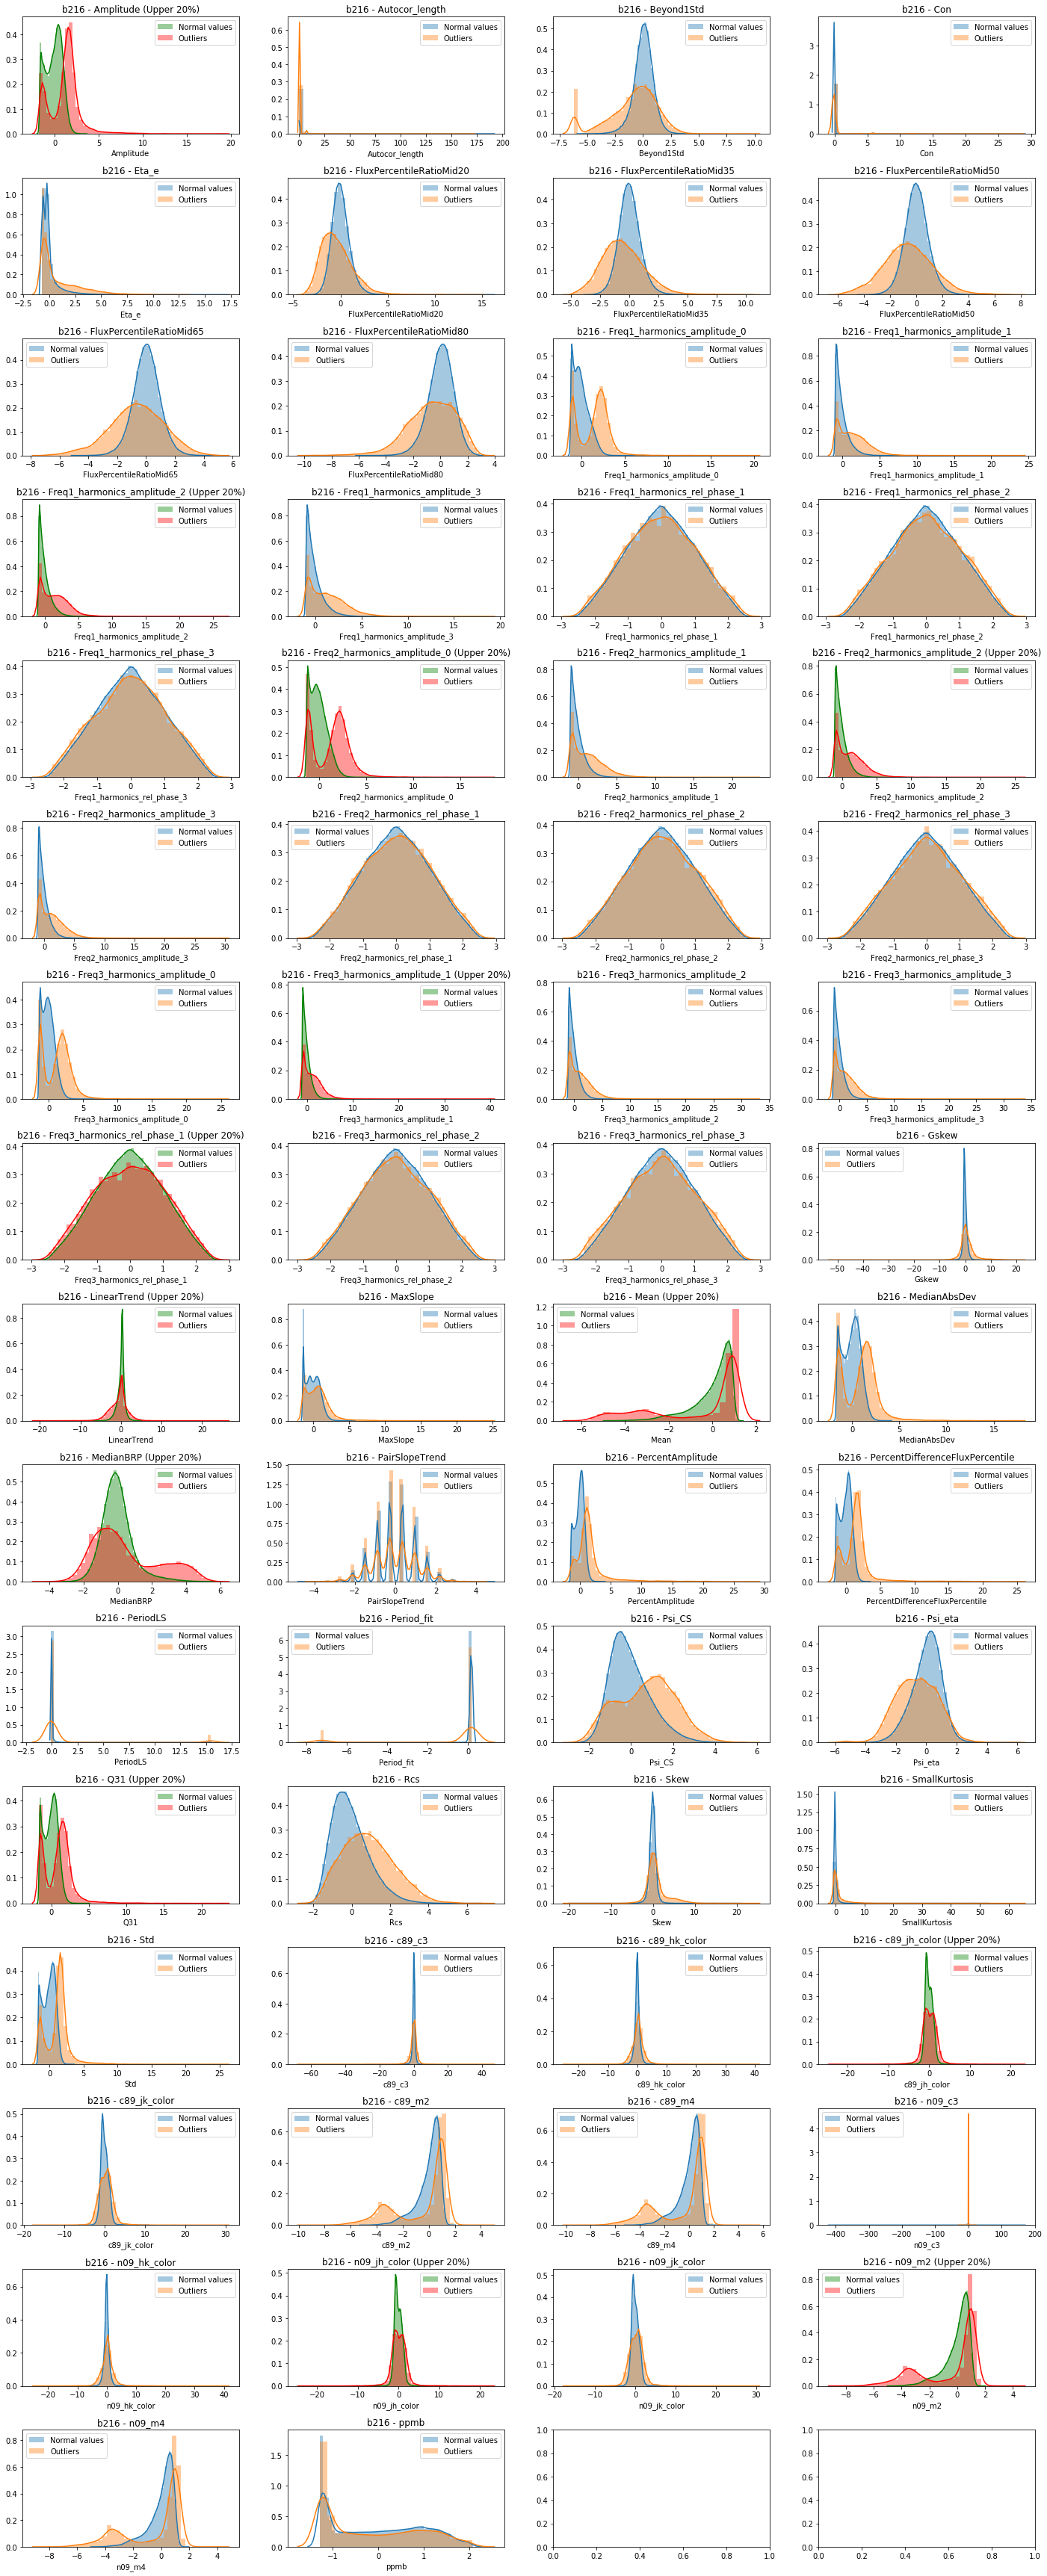

In [7]:
efeats = plot_shaps("b216")
plot_dists("b216", efeats)

plt.tight_layout()

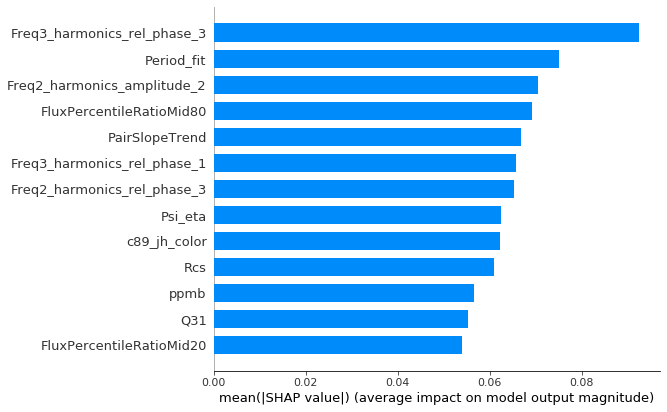

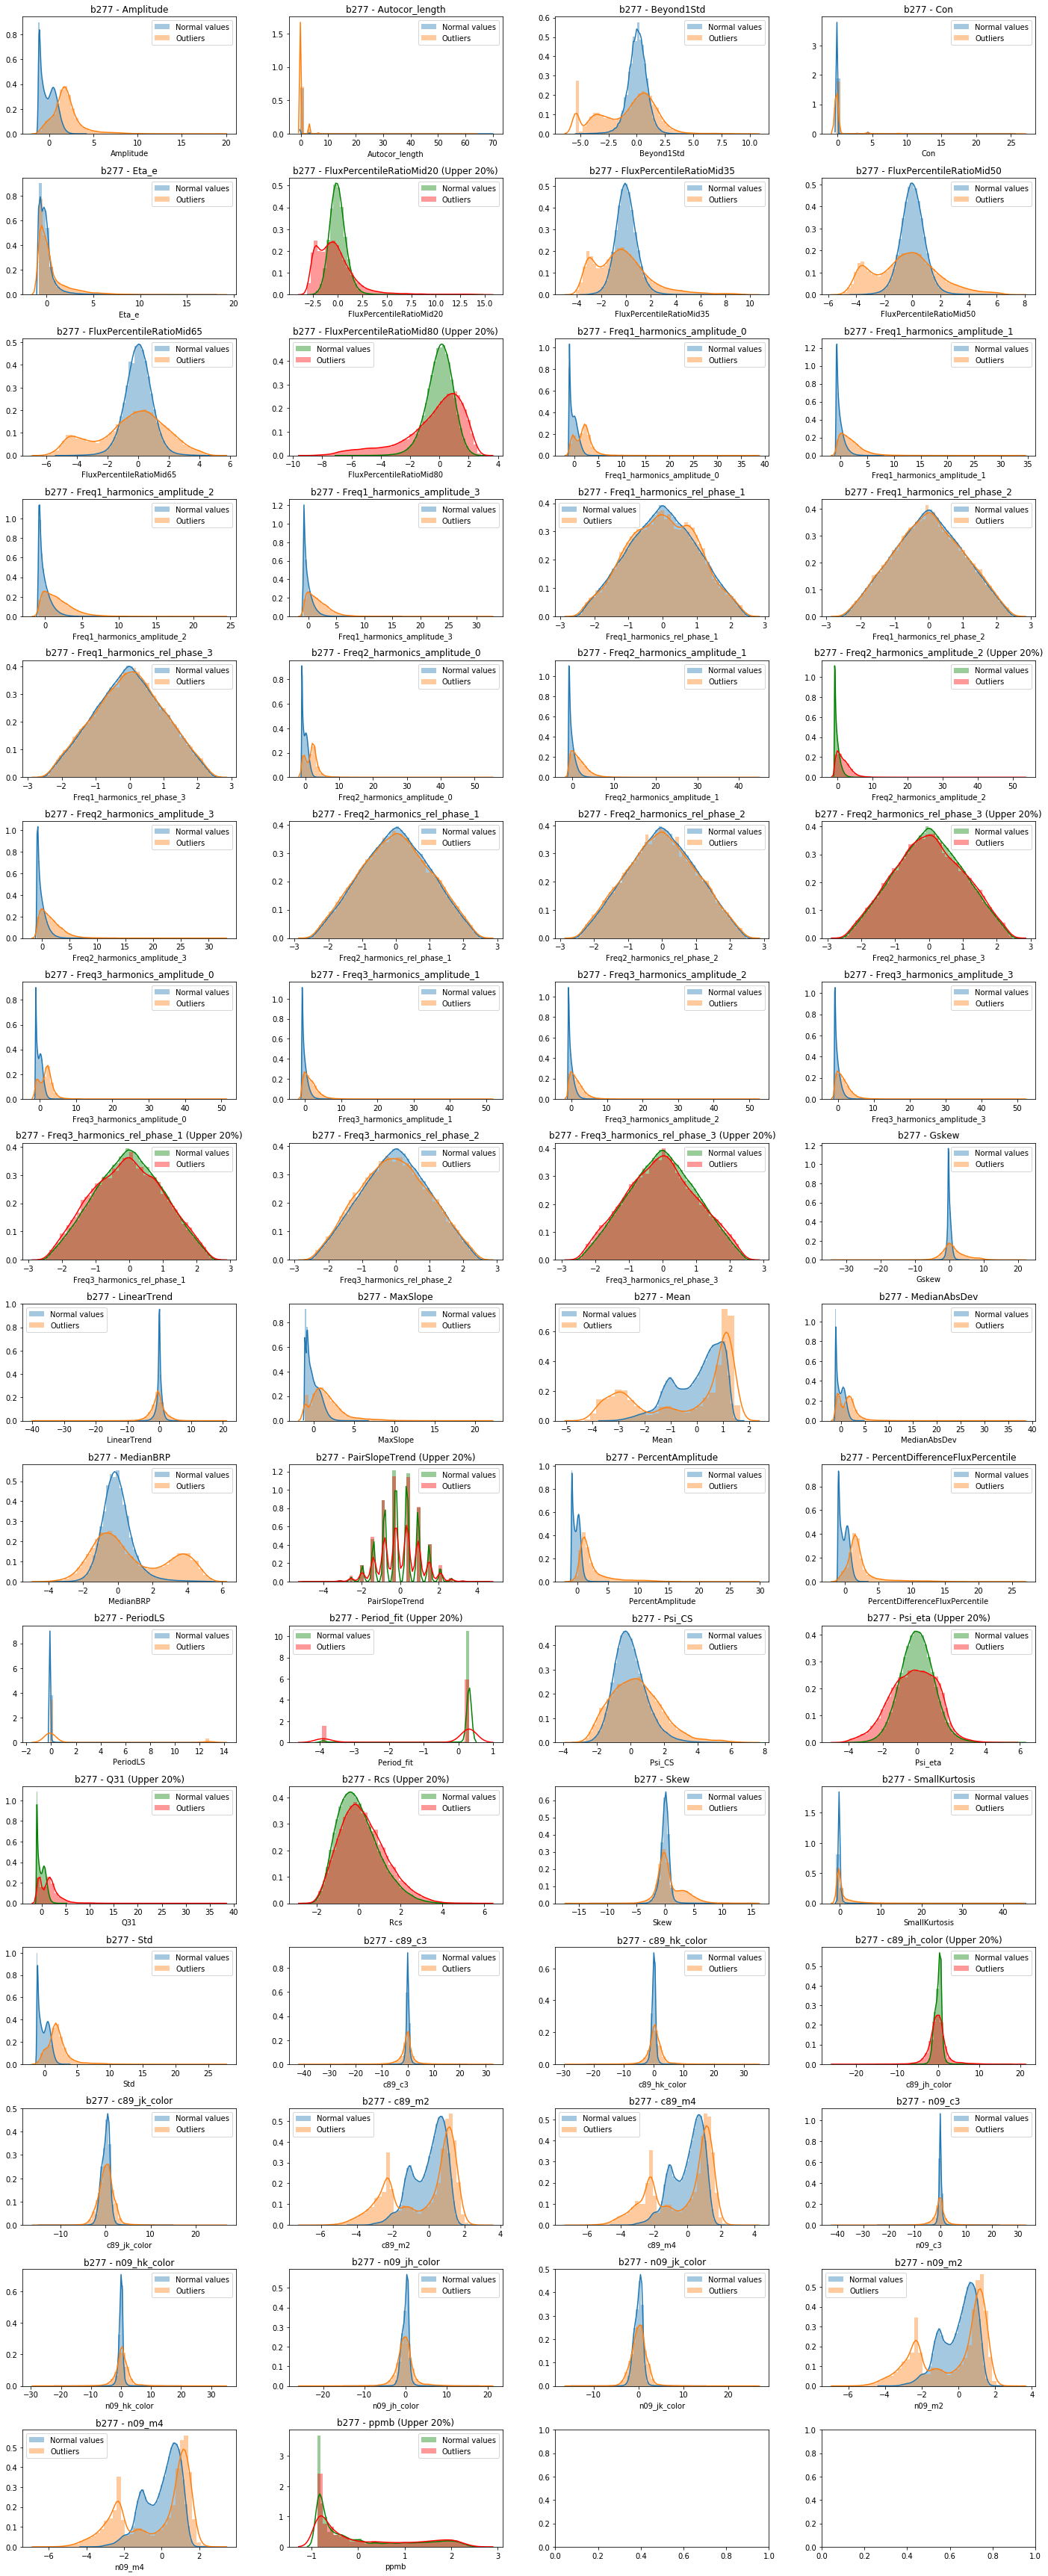

In [9]:
efeats = plot_shaps("b277")
plot_dists("b277", efeats)

plt.tight_layout()